In [169]:
import matplotlib.pyplot as plt
import csv
import random
import math
import numpy as np
import GPy
%matplotlib inline


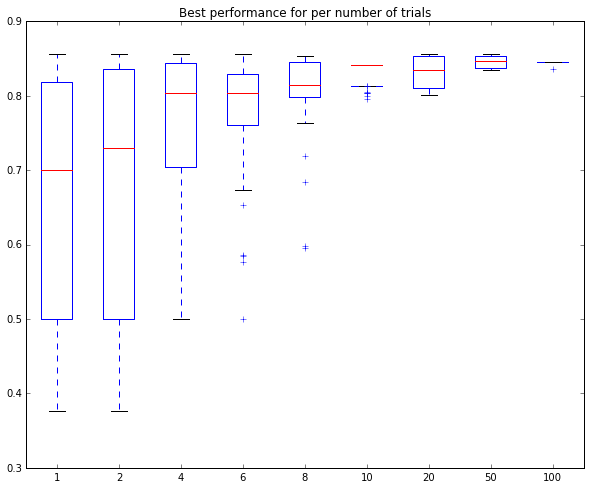

In [170]:
# read in Data:

results=[]
with open('hp_pcc_auc.txt', 'rb') as infile:
    results = list(csv.reader(infile, delimiter='\t'))
results=filter(None,results)

#get AUC:
auc=[x[9] for x in results]
del auc[0]
#replace NA with NaN
auc = [x if x != 'NA' else 'NaN' for x in auc]
auc = [ float(x) for x in auc ]


def sample_data(data,length,size):
    # randomize order of data:
    random.shuffle(data)
    # initialize output array:
    out = []
    # partition data and extract max:
    i=0
    while (i<length):
        out.append( max(data[i : (i+size-1)]))
        i += size
    return out


#auc=auc.reshape((auc.shape[0],1))
d = [auc,
    sample_data(auc, len(auc), 2),
    sample_data(auc, len(auc), 4),
    sample_data(auc, len(auc), 6),
    sample_data(auc, len(auc), 8),
    sample_data(auc, len(auc), 10),
    sample_data(auc, len(auc), 20),
    sample_data(auc, len(auc), 50),
    sample_data(auc, len(auc), 100)]


fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(111)
ax1.set_title("Best performance for per number of trials")
ax1.boxplot(d, labels=["1","2","4","6","8","10","20","50","100"])
plt.show()



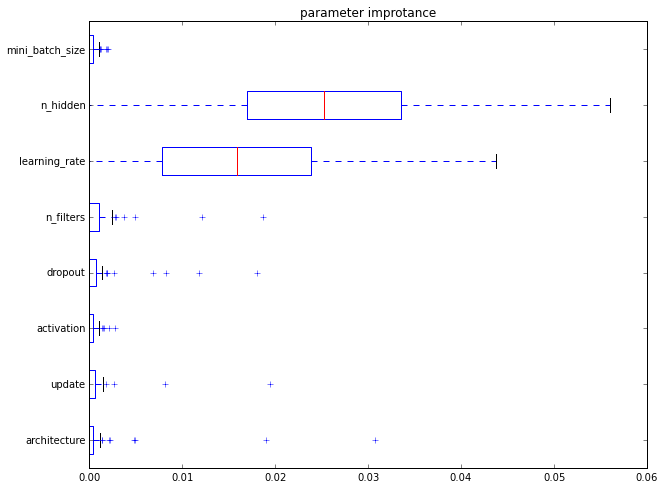

In [171]:

# get hyper parameter settings

architecture = [x[0] for x in results]
update = [x[1] for x in results]
activation = [x[2] for x in results]
dropout = [x[3] for x in results]
n_filters = [x[4] for x in results]
learning_rate = [x[5] for x in results]
n_hidden = [x[6] for x in results]
mini_batch_size = [x[7] for x in results]

del architecture[0]
del update[0]
del activation[0]

del dropout[0]
del n_filters[0]
del learning_rate[0]
del n_hidden[0]
del mini_batch_size[0]

# encode as integers:
_,architecture = np.unique(np.asarray(architecture), return_inverse=True)
_,update = np.unique(np.asarray(update), return_inverse=True)
_,activation = np.unique(np.asarray(activation), return_inverse=True)

# as float:
dropout = [math.log(float(x),10) if x!='0.0' else -1.5 for x in dropout]
n_filters = [math.log(float(x),10) for x in n_filters]
learning_rate = [math.log(float(x),10) for x in learning_rate]
n_hidden = [math.log(float(x),10) for x in n_hidden]
mini_batch_size = [math.log(float(x),10) for x in mini_batch_size]

# shift and scale to unit interval:
architecture = [(x-min(architecture))/(max(architecture)-min(architecture)) for x in architecture]
update = [(x-min(update))/(max(update)-min(update)) for x in update]
activation = [(x-min(activation))/(max(activation)-min(activation)) for x in activation]
dropout = [(x-min(dropout))/(max(dropout)-min(dropout)) for x in dropout]
n_filters = [(x-min(n_filters))/(max(n_filters)-min(n_filters)) for x in n_filters]
learning_rate = [(x-min(learning_rate))/(max(learning_rate)-min(learning_rate)) for x in learning_rate]
n_hidden = [(x-min(n_hidden))/(max(n_hidden)-min(n_hidden)) for x in n_hidden]
mini_batch_size = [(x-min(mini_batch_size))/(max(mini_batch_size)-min(mini_batch_size)) for x in mini_batch_size]

X=[architecture, update, activation, dropout, n_filters, learning_rate, n_hidden, mini_batch_size,auc]

X = (np.asarray(X)).T
#auc = np.asarray(auc).reshape((-1,1))

# remove NaN:
X = X[~np.isnan(X).any(axis=1)]

# np array to hold lengthscale values:
iterations = 50
lscales=np.zeros((X.shape[1]-1,iterations))

# draw random subsamples of data
n=int(math.floor(0.8*X.shape[0]))

for i in range(0,iterations):
    np.random.shuffle(X)
    
    Xn = X[0:n, :-1]
    aucn =(X[0:n:,8]).reshape((-1,1))
    
    # define kernel:
    ker = GPy.kern.Exponential(Xn.shape[1],ARD=True)
    # create model:
    m = GPy.models.GPRegression(Xn,aucn,ker)
    # fit:
    m.optimize(max_f_eval = 10000)
    # save lengthscale:
    lscales[:,i] = m.Exponential.lengthscale


l=[1/x for x in lscales]

# plot 
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(111)
ax1.set_title("parameter improtance")
ax1.boxplot(l, vert=False, labels=["architecture", 
                       "update", 
                       "activation", 
                       "dropout", 
                       "n_filters", 
                       "learning_rate", 
                       "n_hidden", 
                       "mini_batch_size"])
plt.show()
